With the avalibale data from the MLB's Statcast I have pulled all data for each at bat from 2016 - July of 2023. The point of this notebook is to see if a standard ML model can predict the Spray angle.

In [1]:
#imports
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

Loading statcast data from Pybaseball. 

In [2]:
data = pd.read_csv('hit_remove_data.csv')

/tmp/ipykernel_215365/3104724973.py:1: DtypeWarning: Columns (43) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('hit_remove_data.csv')


Visualizing the entire all the data, which includes that adjusted spray angle.

In [3]:
data

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,spin_axis,delta_home_win_exp,delta_run_exp,adj_spray_angle
0,SI,2023-07-01,97.1,-0.69,6.54,"Holmes, Clay",663457,605280,grounded_into_double_play,hit_into_play,...,6,2,2,6,Standard,Standard,223.0,-0.035,-0.412,20.961245
1,FF,2023-07-01,96.0,-1.85,6.08,"Pallante, Andre",641856,669467,grounded_into_double_play,hit_into_play,...,6,2,6,2,Standard,Standard,194.0,0.005,-0.522,23.284572
2,CU,2023-07-01,81.0,-1.76,5.88,"Stratton, Chris",650402,608717,single,hit_into_play,...,6,2,6,2,Standard,Standard,46.0,-0.032,1.346,-25.863480
3,SL,2023-07-01,84.9,-2.04,5.83,"Stratton, Chris",624431,608717,sac_bunt,hit_into_play,...,4,2,4,2,Strategic,Standard,72.0,-0.050,0.059,29.314553
4,FF,2023-07-01,92.3,-1.85,5.84,"Stratton, Chris",683011,608717,single,hit_into_play,...,3,2,3,2,Standard,Standard,215.0,-0.047,0.496,23.446480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901304,FF,2016-04-03,97.9,-1.22,6.40,"Harvey, Matt",519058,518774,field_error,hit_into_play,...,0,0,0,0,Strategic,Standard,215.0,0.024,0.248,19.605722
901305,FF,2016-04-03,96.9,-1.06,6.44,"Harvey, Matt",444876,518774,field_out,hit_into_play,...,0,0,0,0,Standard,Standard,229.0,-0.021,-0.237,-28.011165
901306,SI,2016-04-03,96.9,-1.28,5.51,"Volquez, Edinson",493316,450172,field_out,hit_into_play,...,0,0,0,0,Standard,Standard,242.0,0.010,-0.096,-9.144261
901307,CH,2016-04-03,87.4,-1.41,5.31,"Volquez, Edinson",431151,450172,field_out,hit_into_play,...,0,0,0,0,Standard,Standard,259.0,0.015,-0.144,-30.270483


In [4]:
# Check for NaN values column-wise
columns_without_nan = data.columns[data.isna().any()]

print("Columns without NaN values:")
print(columns_without_nan)

Columns without NaN values:
Index(['pitch_type', 'release_speed', 'release_pos_x', 'release_pos_z',
       'spin_dir', 'spin_rate_deprecated', 'break_angle_deprecated',
       'break_length_deprecated', 'zone', 'des', 'hit_location', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'umpire', 'sv_id', 'vx0',
       'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot', 'hit_distance_sc',
       'launch_speed', 'launch_angle', 'effective_speed', 'release_spin_rate',
       'release_extension', 'release_pos_y', 'estimated_ba_using_speedangle',
       'estimated_woba_using_speedangle', 'woba_denom', 'launch_speed_angle',
       'pitch_name', 'if_fielding_alignment', 'of_fielding_alignment',
       'spin_axis', 'delta_home_win_exp', 'delta_run_exp'],
      dtype='object')


In [5]:
# Remove columns with NaN values
df = data.dropna(axis=1)

Visualizing all the data after removing nan values

In [6]:
df

,game_date,player_name,batter,pitcher,events,description,game_type,stand,p_throws,home_team,...,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,adj_spray_angle
0,2023-07-01,"Holmes, Clay",663457,605280,grounded_into_double_play,hit_into_play,R,L,R,STL,...,3,2,6,2,6,6,2,2,6,20.961245
1,2023-07-01,"Pallante, Andre",641856,669467,grounded_into_double_play,hit_into_play,R,L,R,STL,...,2,2,6,6,2,6,2,6,2,23.284572
2,2023-07-01,"Stratton, Chris",650402,608717,single,hit_into_play,R,R,R,STL,...,3,2,4,4,2,6,2,6,2,-25.863480
3,2023-07-01,"Stratton, Chris",624431,608717,sac_bunt,hit_into_play,R,R,R,STL,...,1,2,3,3,2,4,2,4,2,29.314553
4,2023-07-01,"Stratton, Chris",683011,608717,single,hit_into_play,R,R,R,STL,...,1,2,3,3,2,3,2,3,2,23.446480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901304,2016-04-03,"Harvey, Matt",519058,518774,field_error,hit_into_play,R,L,R,KC,...,4,0,0,0,0,0,0,0,0,19.605722
901305,2016-04-03,"Harvey, Matt",444876,518774,field_out,hit_into_play,R,R,R,KC,...,1,0,0,0,0,0,0,0,0,-28.011165
901306,2016-04-03,"Volquez, Edinson",493316,450172,field_out,hit_into_play,R,R,R,KC,...,3,0,0,0,0,0,0,0,0,-9.144261
901307,2016-04-03,"Volquez, Edinson",431151,450172,field_out,hit_into_play,R,R,R,KC,...,5,0,0,0,0,0,0,0,0,-30.270483


In order to feed out dataframe into a random forest algorithim, we have to change the labels. We do this via LabelEncoder:

In [7]:
# Create a new DataFrame for storing the encoded values
encoded_df = df.copy()

# Iterate over columns and encode non-numeric columns using LabelEncoder
for column in df.columns:
    if df[column].dtype == object:  # Check if column contains non-numeric values
        label_encoder = LabelEncoder()
        encoded_df[column] = label_encoder.fit_transform(df[column])

Spliting our dataframe into features and results:

In [8]:
Y = encoded_df['adj_spray_angle']
X = encoded_df.drop('adj_spray_angle', axis=1)

In [9]:
#visualizing X
X

,game_date,player_name,batter,pitcher,events,description,game_type,stand,p_throws,home_team,...,at_bat_number,pitch_number,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score
0,1468,1131,663457,605280,7,0,3,0,1,25,...,77,3,2,6,2,6,6,2,2,6
1,1468,1842,641856,669467,7,0,3,0,1,25,...,75,2,2,6,6,2,6,2,6,2
2,1468,2367,650402,608717,13,0,3,1,1,25,...,74,3,2,4,4,2,6,2,6,2
3,1468,2367,624431,608717,9,0,3,1,1,25,...,72,1,2,3,3,2,4,2,4,2
4,1468,2367,683011,608717,13,0,3,1,1,25,...,71,1,2,3,3,2,3,2,3,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
901304,0,1041,519058,518774,2,0,3,0,1,11,...,5,4,0,0,0,0,0,0,0,0
901305,0,1041,444876,518774,3,0,3,1,1,11,...,4,1,0,0,0,0,0,0,0,0
901306,0,2542,493316,450172,3,0,3,1,1,11,...,3,3,0,0,0,0,0,0,0,0
901307,0,2542,431151,450172,3,0,3,1,1,11,...,2,5,0,0,0,0,0,0,0,0


In [10]:
# Perform train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = rf_model.predict(X_test)

# Evaluate the model (e.g., calculate the R^2 score)
r2_score = rf_model.score(X_test, Y_test)

In [11]:
r2_score

0.999641191501095

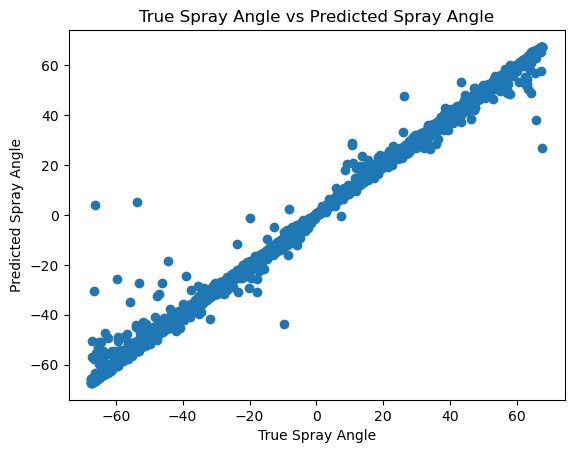

In [12]:
import matplotlib.pyplot as plt

# Assuming you have Y_test and Y_pred as NumPy arrays or pandas Series
# Replace 'Y_test' and 'Y_pred' with your respective variable names

# Create a scatter plot of Y_test vs Y_pred
plt.scatter(Y_test, Y_pred)
plt.xlabel('True Spray Angle')
plt.ylabel('Predicted Spray Angle')
plt.title('True Spray Angle vs Predicted Spray Angle')
plt.show()


We can see that since the R2 score is near, 1, we have a good model. Let us try and see if we reduce the features that are in the model.

In [13]:
# Retrieve the feature importances
feature_importances = rf_model.feature_importances_

# Create a list of feature names
feature_names = list(X_train.columns)

# Sort feature importances in descending order
indices = np.argsort(feature_importances)[::-1]

# Print feature importance rankings
print("Feature Importance Rankings:")
for i in range(len(feature_importances)):
    print(f"{i+1}. {feature_names[indices[i]]}: {feature_importances[indices[i]]:.4f}")

Feature Importance Rankings:
1. hc_x: 0.4377
2. stand: 0.3143
3. hc_y: 0.1720
4. bb_type: 0.0564
5. iso_value: 0.0099
6. woba_value: 0.0094
7. fielder_8: 0.0000
8. fielder_7: 0.0000
9. fielder_5: 0.0000
10. batter: 0.0000
11. fielder_4: 0.0000
12. player_name: 0.0000
13. away_team: 0.0000
14. fielder_9: 0.0000
15. fielder_3: 0.0000
16. fielder_6: 0.0000
17. fielder_2: 0.0000
18. at_bat_number: 0.0000
19. home_team: 0.0000
20. fielder_2.1: 0.0000
21. pitcher: 0.0000
22. pitch_number: 0.0000
23. game_pk: 0.0000
24. pitcher.1: 0.0000
25. game_date: 0.0000
26. post_bat_score: 0.0000
27. inning: 0.0000
28. bat_score: 0.0000
29. outs_when_up: 0.0000
30. post_home_score: 0.0000
31. post_away_score: 0.0000
32. home_score: 0.0000
33. post_fld_score: 0.0000
34. away_score: 0.0000
35. balls: 0.0000
36. fld_score: 0.0000
37. game_year: 0.0000
38. strikes: 0.0000
39. events: 0.0000
40. inning_topbot: 0.0000
41. babip_value: 0.0000
42. p_throws: 0.0000
43. game_type: 0.0000
44. type: 0.0000
45. desc

In [14]:
#Visualizing the list of features
feature_importances

array([7.94985256e-06, 1.37476933e-05, 1.55473141e-05, 9.45678882e-06,
       2.32801872e-06, 0.00000000e+00, 6.55246982e-07, 3.14328038e-01,
       1.61770492e-06, 1.02302901e-05, 1.33949317e-05, 0.00000000e+00,
       5.63930450e-02, 3.62241191e-06, 2.95889679e-06, 3.03781539e-06,
       4.86280167e-06, 5.77035721e-06, 1.91970495e-06, 4.37670175e-01,
       1.72014193e-01, 1.08996973e-05, 8.97228181e-06, 8.47300725e-06,
       1.01766918e-05, 1.15875565e-05, 1.51327133e-05, 1.67640841e-05,
       1.13635544e-05, 1.70894910e-05, 1.79801224e-05, 1.30310017e-05,
       9.43539327e-03, 1.88539180e-06, 9.86345334e-03, 1.08787005e-05,
       8.97831489e-06, 3.91013525e-06, 3.68350663e-06, 5.35623794e-06,
       3.21287747e-06, 4.56852864e-06, 4.68430935e-06, 6.11835589e-06,
       3.85627792e-06])

Now we will remove the non-important features, and make the model run faster

In [15]:
# Define a threshold to determine the importance cutoff
importance_threshold = 0.008

# Get the indices of columns to remove based on the importance threshold
columns_to_remove_indices = [index for index, importance in enumerate(feature_importances) if importance <= importance_threshold]

# Create a new DataFrame with only the important features
reduced_X = X.drop(X.columns[columns_to_remove_indices], axis=1)

# Print the new DataFrame
print(reduced_X)

        stand  bb_type    hc_x    hc_y  woba_value  iso_value
0           0        1  107.10  163.74         0.0          0
1           0        1  105.11  164.53         0.0          0
2           1        2   62.46  106.61         0.9          0
3           1        1  132.17  189.96         0.9          0
4           1        2  182.19  104.76         0.9          0
...       ...      ...     ...     ...         ...        ...
901304      0        2   70.05   85.45         0.9          0
901305      1        1  106.09  172.94         0.0          0
901306      1        1  116.76  158.19         0.0          0
901307      1        1  100.00  168.36         0.0          0
901308      0        2  133.00   52.39         0.0          0

[901309 rows x 6 columns]


In [16]:
# Perform train-test split
X_train, X_test, Y_train, Y_test = train_test_split(reduced_X, Y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = rf_model.predict(X_test)

# Evaluate the model (e.g., calculate the R^2 score)
r2_score = rf_model.score(X_test, Y_test)

In [17]:
r2_score

0.9997803728586763

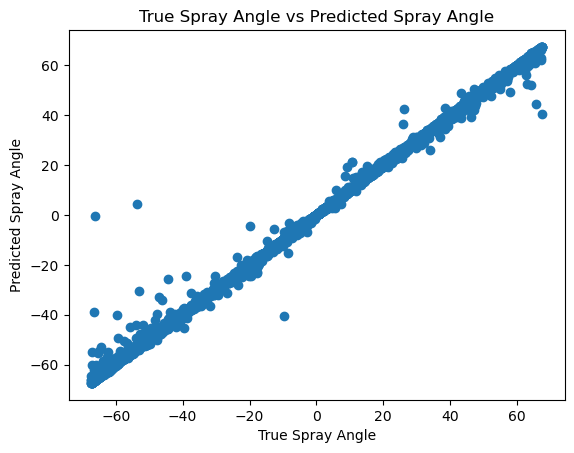

In [18]:
# Create a scatter plot of Y_test vs Y_pred
plt.scatter(Y_test, Y_pred)
plt.xlabel('True Spray Angle')
plt.ylabel('Predicted Spray Angle')
plt.title('True Spray Angle vs Predicted Spray Angle')
plt.show()


Now we apply two feature scalers to see if this changes our result.

0.9997882739929449


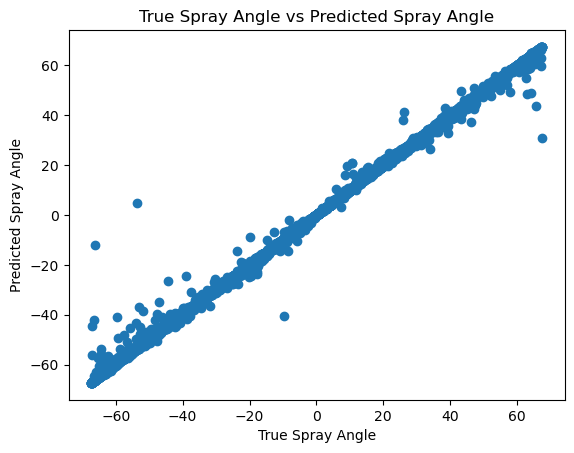

In [19]:
# Create an instance of StandardScaler
scaler = StandardScaler()

# Fit the scaler to your data
scaler.fit(reduced_X)

# Transform the data
X_scaled = scaler.transform(reduced_X)

# Perform train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = rf_model.predict(X_test)

# Evaluate the model (e.g., calculate the R^2 score)
r2_score = rf_model.score(X_test, Y_test)

print(r2_score)
# Create a scatter plot of Y_test vs Y_pred
plt.scatter(Y_test, Y_pred)
plt.xlabel('True Spray Angle')
plt.ylabel('Predicted Spray Angle')
plt.title('True Spray Angle vs Predicted Spray Angle')
plt.show()


0.9997600823305077


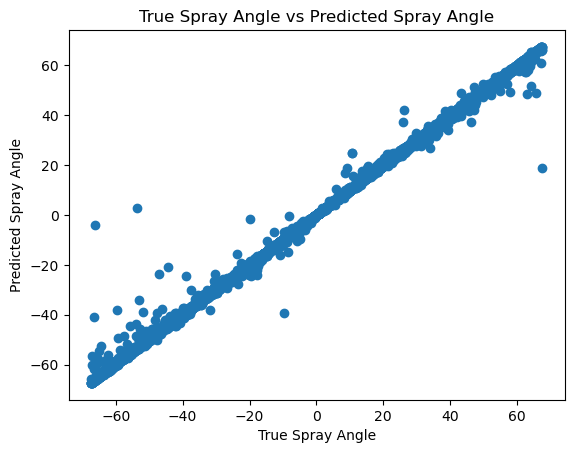

In [20]:
# Create an instance of MinMaxScaler
scaler = MinMaxScaler()

# Fit the scaler to your data
scaler.fit(reduced_X)

# Transform the data
X_scaled = scaler.transform(reduced_X)

# Perform train-test split
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest Regressor model
rf_model = RandomForestRegressor(n_jobs=-1)
rf_model.fit(X_train, Y_train)

# Predict on the test set
Y_pred = rf_model.predict(X_test)

# Evaluate the model (e.g., calculate the R^2 score)
r2_score = rf_model.score(X_test, Y_test)

print(r2_score)
# Create a scatter plot of Y_test vs Y_pred
plt.scatter(Y_test, Y_pred)
plt.xlabel('True Spray Angle')
plt.ylabel('Predicted Spray Angle')
plt.title('True Spray Angle vs Predicted Spray Angle')
plt.show()


So the R2 socore still stays the same. Which tells us that the model is performing at its best.